In [4]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [6]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 1
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

## NER 데이터 전처리
- 한국어 개체명 인식 데이터를 버트로 학습하려면 데이터 구조를 변경해야함
- 기존 학습 데이터의 라벨은 띄어쓰기 단위로 나눠짐
    - 따라서 버트 토크나이저를 활용할땐 기존 데이터 구조와 달라지기 때문에 토큰에 맞게 재배치 해주어야함.
    - 즉, 해당 분류에 맞게 각 라벨 데이터를 수정하는 추가작업이 필요함
    

In [7]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

# 데이터 개수를 보존하기 위해 Open으로 불러옴. (바로 판다스로 안불러오고)
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))



개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [8]:
train_ner_df.head()

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [9]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


In [10]:
ner_labels[:10]
# O: 개체명이 아닌 부분
# I: 개체명 내부
# B: 개체명 시작

['UNK',
 'O',
 'PER-B',
 'PER-I',
 'FLD-B',
 'FLD-I',
 'AFW-B',
 'AFW-I',
 'ORG-B',
 'ORG-I']

현재 라벨의 구조를 버트 토크나이저에 맞게 변환해보자.

In [11]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                         cache_dir='bert_ckpt')


# 인식에 필요한 값 외에는 모두 0으로 처리함
# print(tokenizer.pad_token_id)
pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0



In [15]:
# 버트 토크나이저를 불러오고, encode_plus 기능을 통해 
# input_id, attention_mask, token_type_id를 생성함
# 이것은 버트 모델에 들어갈 인풋!
def bert_tokenizer(sent, MAX_LEN):
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation = True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN, # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids'] 
    attention_mask = encoded_dict['attention_mask'] # 패딩부분은 0
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id


# 띄어쓰기 단위에 맞게 구성된 라벨을 버트 토크나이저에 맞는 형태로 변형하기
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
    tokens = []
    label_ids = []
    # words: sentence.split()
    for word, slot_label in zip(words, labels_idx):
        
        # 버트 토크나이저로 토큰화
        word_tokens = tokenizer.tokenize(word)
        
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        # 슬롯 레이블값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            # 원래 B 레이블 1개와 I로 지정한 레이블을 토큰 개수-1만큼 생성
            label_ids.extend([int(slot_label)] + [int(slot_label)+1] * (len(word_tokens) - 1))
        
        else:
            # 레이블을 토큰 개수만큼 생성하기
            label_ids.extend([int(slot_label)] * len(word_tokens))
    
    # [CLS] and [SEP] 설정
    special_tokens_count = 2 # cls, sep
    
    # max_len보다 레이블 개수많으면 자르기
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]
    
    # 마지막에 [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # 첫부분에 [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    # cls_token_id / label_ids / sep_token_id / pad_token_id
    return label_ids


In [16]:
# 테스트용

bert_tokenizer('안녕하세요 반갑', 10)

ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [17]:
# B가 포함된 label의 인덱스
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

# 각 구성요소들을 활용해 학습 데이터를 제작하는 함수
# 버트의 학습에 필요한 입력과 라벨을 반환함
def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []
    
    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split() # 문장을 띄어쓰기 단위로 나눈거
        labels = labels.split() # 레이블을 띄어쓰기 단위로 나눔
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index('UNK'))
        
        assert len(words) == len(labels_idx)
        
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)
        
    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list
    


train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)



## NER 모델 구성

In [18]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name,
                                               cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name="ner_classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, 
                  attention_mask=attention_mask, 
                  token_type_ids=token_type_ids)
        
        sequence_output = outputs[0] # 임베딩 크기(버트 베이스 차원 크기) x 최대 문장 길이 (768x111)
        sequence_output = self.dropout(sequence_output, 
                                       training=training)
        
        # 시퀀스 111개를 해당 개체명 라벨의 개수(30개)로 각각 분류함
        logits = self.classifier(sequence_output)
        
        return logits

In [19]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels)) # 30

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
# 시퀀스 분류 문제는 손실함수를 직접 지정해줘야함
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE
    )
    
    # 0의 레이블 값은 손실 값을 계산할 때 제외
    # reshape을 통해 배치차원 없앰. 1차원으로 변경 (마스킹 처리를 손쉽게 하려고)
    active_loss = tf.reshape(labels, (-1,)) != 0
    
    # 마스킹 적용 (True 제외하고 다 제거함)
    # logits 배치차원 없앰. 최종 2차원
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), 
                                     active_loss)
    
    labels = tf.boolean_mask(tf.reshape(labels, (-1, )),
                            active_loss)
    
    return loss_fn(labels, reduced_logits)
    


In [21]:
# F1 스코어 구현
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval
        
    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }
    
    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
      
    def on_epoch_end(self, epoch, logs=None): # override
        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)
        
        slot_label_map = {i: label for i, label in enumerate(ner_labels)}
        
        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]
        
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

In [22]:
f1_score_callback = F1Metrics(test_inputs, test_labels)
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [23]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)


data_out/KOR/tf2_bert_ner -- Folder already exists 



## NER 모델 학습 및 테스트

In [24]:

history = ner_model.fit(train_inputs, 
                        train_labels, 
                        batch_size=BATCH_SIZE, 
                        epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x109d94d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x109d94d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2532/2532 [==============================] - 41245s 16s/step - loss: 0.5929


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


********
F1 Score
f1, 0.7465
precision, 0.7163
recall, 0.7794


/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         AFW       0.40      0.45      0.43       393
         ANM       0.50      0.73      0.60       699
         CVL       0.66      0.72      0.69      5735
         DAT       0.80      0.89      0.85      2510
         EVT       0.63      0.72      0.67      1093
         FLD       0.51      0.46      0.48       228
         LOC       0.65      0.78      0.71      2124
         MAT       0.12      0.08      0.10        12
         NUM       0.86      0.88      0.87      5544
         ORG       0.73      0.76      0.74      4055
         PER       0.74      0.83      0.79      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.77      0.87      0.82       314
         TRM       0.58      0.60      0.59      1950

   micro avg       0.72      0.78      0.75     29103
   macro avg       0.57      0.63      0.60     29103
weighted avg       0.72      0.78      0.75     29103

********
{'loss': [0.435

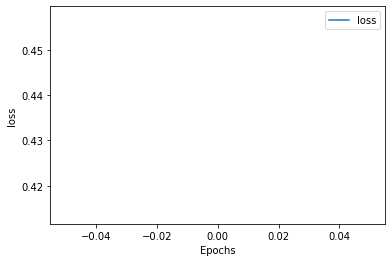

In [25]:
plot_graphs(history, 'loss')